# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [ ]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated

    @property
    def x_diff(self):
        return self.x_max - self.x_min

    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        )
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        )
        return True

    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [ ]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

11501568/11490434 [==============================] - 0s 0us/step


Let us have a look at example canvas (rotated digits have additional *added to description).

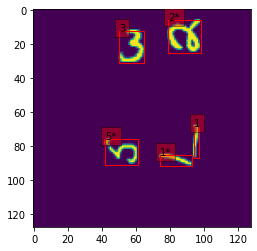

In [ ]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

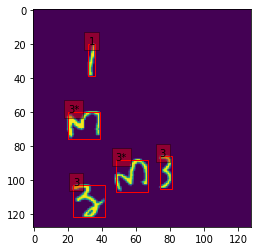

In [ ]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

In [ ]:
import collections
import matplotlib.pyplot as plt


ANALYZE_CANVAS_SIZE = 10

ANALYZE_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(ANALYZE_CANVAS_SIZE)
]

y_len=[]
x_len=[]
for canvas in ANALYZE_CANVAS:
    for box in canvas.boxes:
        print(box.x_diff, box.y_diff)
        x_len.append(box.x_diff)
        y_len.append(box.y_diff)
np.min(x_len),np.max(x_len),2
np.min(y_len),np.max(y_len),2
ANCHOR_SIZES = [np.mean(x_len),np.mean(y_len)] # TODO
#better use min/max: 5-19 step 2

print("ANCHOR_SIZES:", ANCHOR_SIZES)

17 19
11 19
19 15
19 19
19 9
19 17
19 17
19 13
17 19
19 17
19 13
15 19
19 8
19 6
19 19
19 15
19 19
15 19
19 18
19 19
19 12
13 19
19 11
15 19
19 15
7 19
19 17
19 9
19 17
17 19
19 11
19 13
19 15
16 19
19 12
15 19
19 13
15 19
13 19
5 19
19 13
19 19
19 10
19 19
19 10
19 15
15 19
ANCHOR_SIZES: [17.319148936170212, 15.74468085106383]


13 19
19 7
19 13
13 19
19 17
13 19
17 19
15 19
19 19
19 17
19 19
19 11
16 19
19 19
16 19
19 15
19 19
15 19
13 19
19 5
19 4
19 18
8 19
19 19
19 15
6 19
13 19
19 19
19 19
12 19
19 7
15 19
16 19
19 17
19 17
19 18
19 19
19 15
18 19
19 15
16 19
17 19
19 19
19 9
19 15
19 19
19 7
19 5
19 16
19 17
11 19
19 5
19 15
19 11
19 16
13 19
15 19
13 19
19 10
19 10
17 19
19 19
19 16
19 13
19 15
19 19
19 6
19 17
19 4
19 17
3 19
19 15
19 7
19 19
19 19
15 19
19 17
19 3
17 19
19 18
19 9
19 19
15 19
19 18
19 18
19 19
19 9
14 19
17 19
19 16
19 19
19 3
19 13
19 5
17 19
19 5
19 19
19 13
19 19
19 14
19 11
19 5
19 11
19 15
17 19
17 19
11 19
17 19
17 19
16 19
19 13
17 19
19 7
19 19
15 19
19 19
11 19
19 15
17 19
19 17
19 19
15 19
19 7
19 11
17 19
19 15
19 13
19 7
19 15
19 18
19 15
19 19
13 19
19 19
19 14
9 19
17 19
19 19
19 13
19 19
15 19
19 11
19 16
13 19
13 19
17 19
19 5
13 19
19 17
19 15
19 17
19 19
19 13
15 19
19 5
17 19
19 17
16 19
19 17
19 13
19 19
19 19
17 19
19 19
19 17
19 15
15 19
19 9
17 19
19 17
19 16
7 

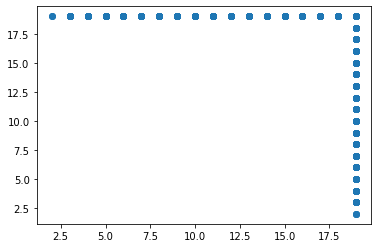

In [ ]:
import collections
import matplotlib.pyplot as plt


ANALYZE_CANVAS_SIZE = 1000

ANALYZE_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(ANALYZE_CANVAS_SIZE)
]

y_len=[]
x_len=[]
for canvas in ANALYZE_CANVAS:
    for box in canvas.boxes:
        print(box.x_diff, box.y_diff)
        x_len.append(box.x_diff)
        y_len.append(box.y_diff)
np.min(x_len),np.max(x_len),2
np.min(y_len),np.max(y_len),2
ANCHOR_SIZES = [np.mean(x_len),np.mean(y_len)] # TODO
#better use min/max: 5-19 step 2



print("ANCHOR_SIZES:", ANCHOR_SIZES)

plt.scatter(x=x_len,y=y_len)

In [ ]:
ANCHOR_SIZES = [(19, 12), (12, 19), (17, 17), (5, 19), (19, 5)]

### Model building (2pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [ ]:
from numpy.core.fromnumeric import mean
from torch import nn


class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux

class DigitClassificationHead(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 5*5, (3, 3), padding=1),)
  def forward(self, backbone_output):
      output = self.conv(backbone_output)
      output = output.permute(0, 2, 3, 1) #this will make sure reshape will work good
      digit_classification_output = output.reshape(-1, 5)
      return digit_classification_output

class RotationClassificationHead(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 2*5, (3, 3), padding=1),)

  def forward(self, backbone_output):
      output = self.conv(backbone_output)
      output = output.permute(0, 2, 3, 1)
      rotation_classification_output = output.reshape(-1, 2)
      return rotation_classification_output

class BoxRegressionHead(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 4*5, (3, 3), padding=1),)
  def forward(self, backbone_output):
      output = self.conv(backbone_output)
      output = output.permute(0, 2, 3, 1)
      box_regression_output = output.reshape(-1, 4)
      return box_regression_output




class DigitDetectionModel(torch.nn.Module):
  def __init__(self):
        super().__init__()
        self.backbone = Backbone()
        self.𝚍𝚒𝚐𝚒𝚝𝙲𝚕𝚊𝚜𝚜𝚒𝚏𝚒𝚌𝚊𝚝𝚒𝚘𝚗𝙷𝚎𝚊𝚍 = DigitClassificationHead()
        self.𝚛𝚘𝚝𝚊𝚝𝚒𝚘𝚗𝙲𝚕𝚊𝚜𝚜𝚒𝚏𝚒𝚌𝚊𝚝𝚒𝚘𝚗𝙷𝚎𝚊𝚍 = RotationClassificationHead()
        self.𝚋𝚘𝚡𝚁𝚎𝚐𝚛𝚎𝚜𝚜𝚒𝚘𝚗𝙷𝚎𝚊𝚍 = BoxRegressionHead()
        self.anchors = []

        for i in range(16):
          for j in range(16):
            for size in ANCHOR_SIZES:
              self.anchors.append(MnistBox(8*(i+0.5)-size[0]/2, 8*(j+0.5)-size[1]/2, 8*(i+0.5)+size[0]/2, 8*(j+0.5)+size[1]/2))


  def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
      x = self.backbone(x)
      digit_classification_output = self.𝚍𝚒𝚐𝚒𝚝𝙲𝚕𝚊𝚜𝚜𝚒𝚏𝚒𝚌𝚊𝚝𝚒𝚘𝚗𝙷𝚎𝚊𝚍(x)
      rotation_classification_output = self.𝚛𝚘𝚝𝚊𝚝𝚒𝚘𝚗𝙲𝚕𝚊𝚜𝚜𝚒𝚏𝚒𝚌𝚊𝚝𝚒𝚘𝚗𝙷𝚎𝚊𝚍(x)
      box_regression_output = self.𝚋𝚘𝚡𝚁𝚎𝚐𝚛𝚎𝚜𝚜𝚒𝚘𝚗𝙷𝚎𝚊𝚍(x)
      return DigitDetectionModelOutput(self.anchors, digit_classification_output, rotation_classification_output, box_regression_output)




### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner:

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [ ]:
from torchvision.ops import box_iou, nms


class DigitDetectionModelTarget:

    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.3,
        nb_of_classes: int = 5,
    ) -> DigitDetectionModelTarget:
        matched_anchors = []
        digit_classification_target = torch.zeros((len(anchors),5))
        rotation_classification_target = torch.zeros((len(anchors),2))
        box_regression_target = torch.zeros((len(anchors),4))
        for i in range(len(anchors)):
          gt_box = None
          best_iou = 0
          anchor = anchors[i]
          for box in canvas.boxes:
            iou = anchor.iou_with(box)
            if iou > iou_threshold and iou > best_iou:
              gt_box = box
              best_iou = iou
          if gt_box is not None:
            digit_classification_target[i, gt_box.class_nb - 1] = 1
            rotation_classification_target[i, gt_box.rotated] = 1
            box_regression_target[i,0] = gt_box.x_min - anchor.x_min
            box_regression_target[i,1] = gt_box.x_max - anchor.x_max
            box_regression_target[i,2] = gt_box.y_min - anchor.y_min
            box_regression_target[i,3] = gt_box.y_max - anchor.y_max
            matched_anchors.append(i)
        return DigitDetectionModelTarget(digit_classification_target, rotation_classification_target, box_regression_target, matched_anchors)


    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
      prediction = []
      scores = []
      for i in range(len(model_output.anchors)):
        if torch.sigmoid(model_output.digit_classification_output[i]).max() > 0.6:
          prediction.append(MnistBox(
            (model_output.anchors[i].x_min + model_output.box_regression_output[i, 0]).item(),
            (model_output.anchors[i].y_min + model_output.box_regression_output[i, 2]).item(),
            (model_output.anchors[i].x_max + model_output.box_regression_output[i, 1]).item(),
            (model_output.anchors[i].y_max + model_output.box_regression_output[i, 3]).item(),
            (torch.argmax(model_output.digit_classification_output[i]) + 1).item(),
            torch.sigmoid(model_output.rotation_classification_output[i].max()) > 0.5
          ))

          scores.append(torch.sigmoid(model_output.digit_classification_output[i].max()))


      prediction = np.array(prediction)
      boxes = [[box.x_min, box.y_min, box.x_max, box.y_max] for box in prediction]
      boxes = torch.Tensor(np.array(boxes)).reshape(-1, 4)
      scores = torch.Tensor(scores)

      ind = nms(boxes, scores, 0.1)
      ind = np.array(ind)
      prediction = list(prediction[ind])

      return prediction

### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`:

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class  and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [ ]:
import torch
import torchvision


class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
        matched_anchors = model_target.matched_anchors

        if not matched_anchors:
            return None

        box_regression_loss = torch.nn.functional.smooth_l1_loss(model_output.box_regression_output, model_target.box_regression_target, reduction='mean') / len(matched_anchors)
        digit_classification_loss = torchvision.ops.sigmoid_focal_loss(model_output.digit_classification_output, model_target.digit_classification_target, reduction='mean')
        rotation_classification_loss = torchvision.ops.sigmoid_focal_loss(model_output.rotation_classification_output, model_target.rotation_classification_target, reduction='mean')

        return box_regression_loss + digit_classification_loss + rotation_classification_loss

class DigitAccuracy:

    def compute_metric  (
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
      if len(canvas.boxes) != len(predicted_boxes):
        return 0

      for box in canvas.boxes:
        matched = 0

        for pred_box in predicted_boxes:
          if box.class_nb == pred_box.class_nb and box.rotated ==  pred_box.rotated and box.iou_with(pred_box) > 0.5:
            matched += 1

        if matched != 1:
          return 0

      return 1

In [ ]:
dec = TargetDecoder()
model = DigitDetectionModel().to(DEVICE)
anchors = model.anchors

model_output = model(TEST_CANVAS[10])
model_target = dec.get_targets(TEST_CANVAS[10], anchors)

retina_loss = RetinaLoss()

retina_loss.compute_loss(model_output, model_target)
#print(model_output.box_regression_output.shape)



tensor(0.2622, grad_fn=<AddBackward0>)

### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

In [ ]:
train_data_size = 1000

train_data = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(train_data_size)
]

In [ ]:
import torch.optim as optim

target_decoder = TargetDecoder()
digit_accuracy = DigitAccuracy()
n_epochs = 10

retina_loss = RetinaLoss()
lr = 0.0005


model = DigitDetectionModel()
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

def train(model, train_data, optim):
    model.train()

    train_loss = 0
    train_correct = 0

    for i, data in enumerate(train_data):
        optimizer.zero_grad()
        output = model(data)
        target = target_decoder.get_targets(data, output.anchors)
        loss = retina_loss.compute_loss(output, target)
        if loss is not None:
          train_loss += loss.item()
          pred = target_decoder.get_predictions(output)
          train_correct += digit_accuracy.compute_metric(pred, data)
          loss.backward()
          optimizer.step()
        if i%100 == 0:
          print(loss)
          print(train_correct)

    return train_loss / len(train_data), train_correct * 100 / len(train_data)


for epoch in range(n_epochs):
  print(epoch)
  train(model, train_data, optimizer)

0
tensor(0.2598, grad_fn=<AddBackward0>)
0
tensor(0.0160, grad_fn=<AddBackward0>)
0
tensor(0.0097, grad_fn=<AddBackward0>)
0
tensor(0.0086, grad_fn=<AddBackward0>)
0
tensor(0.0067, grad_fn=<AddBackward0>)
0
tensor(0.0073, grad_fn=<AddBackward0>)
0
tensor(0.0057, grad_fn=<AddBackward0>)
0
tensor(0.0057, grad_fn=<AddBackward0>)
0
tensor(0.0059, grad_fn=<AddBackward0>)
0
tensor(0.0050, grad_fn=<AddBackward0>)
0
1
tensor(0.0086, grad_fn=<AddBackward0>)
0
tensor(0.0046, grad_fn=<AddBackward0>)
0
tensor(0.0046, grad_fn=<AddBackward0>)
0
tensor(0.0060, grad_fn=<AddBackward0>)
0
tensor(0.0045, grad_fn=<AddBackward0>)
0
tensor(0.0045, grad_fn=<AddBackward0>)
0
tensor(0.0042, grad_fn=<AddBackward0>)
0
tensor(0.0037, grad_fn=<AddBackward0>)
0
tensor(0.0030, grad_fn=<AddBackward0>)
0
tensor(0.0043, grad_fn=<AddBackward0>)
0
2
tensor(0.0053, grad_fn=<AddBackward0>)
0
tensor(0.0032, grad_fn=<AddBackward0>)
2
tensor(0.0036, grad_fn=<AddBackward0>)
4
tensor(0.0033, grad_fn=<AddBackward0>)
6
tensor(0.0

In [ ]:
def test(model, test_data):
    model.eval()

    test_loss = 0
    test_correct = 0

    for i, data in enumerate(test_data):
        output = model(data)
        target = target_decoder.get_targets(data, output.anchors)
        loss = retina_loss.compute_loss(output, target)
        test_loss += loss.item()
        pred = target_decoder.get_predictions(output)
        test_correct += digit_accuracy.compute_metric(pred, data)
        canva = MnistCanvas(data.image, pred)
        canva.plot()

    return test_loss / len(test_data), test_correct * 100 / len(test_data)


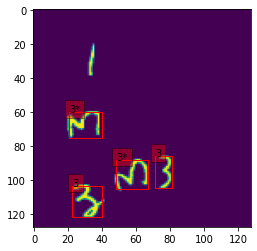

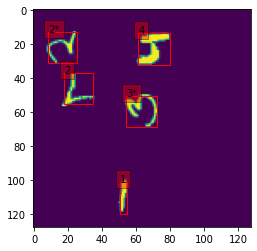

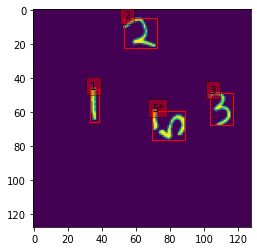

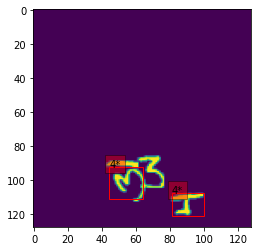

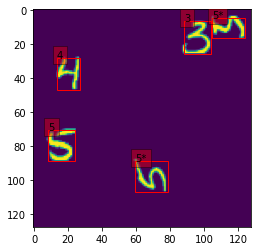

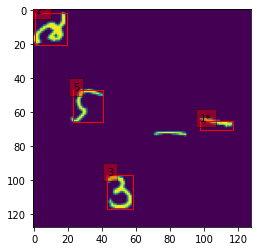

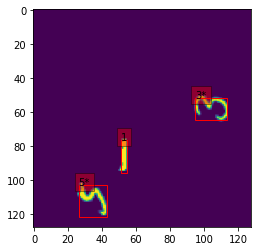

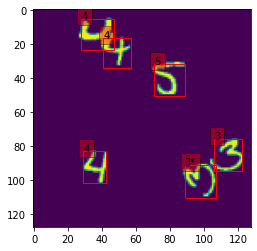

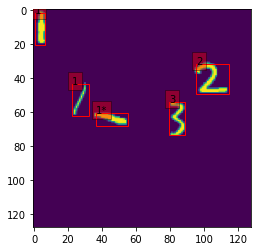

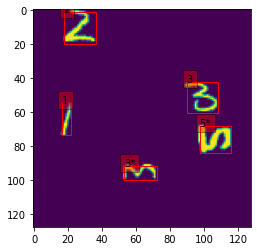

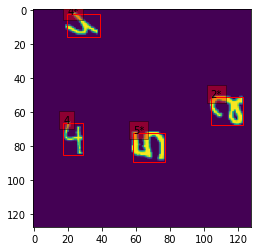

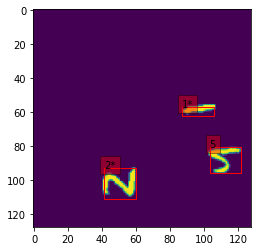

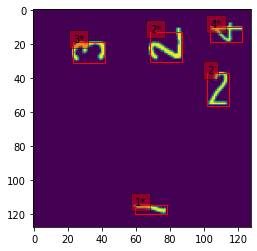

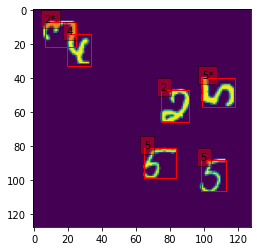

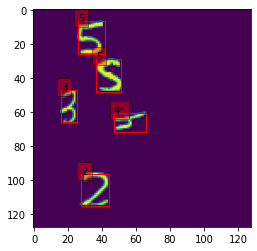

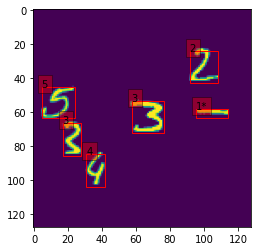

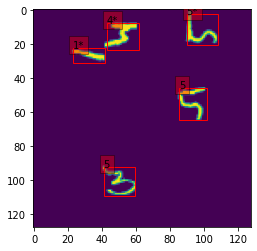

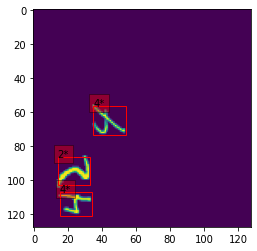

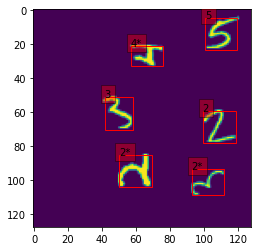

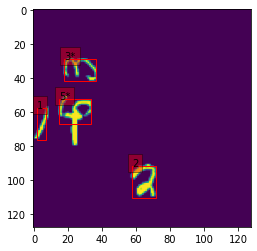

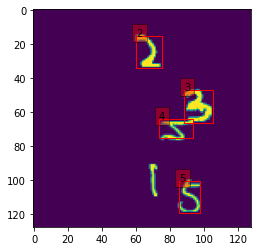

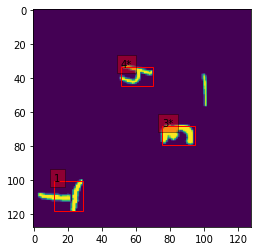

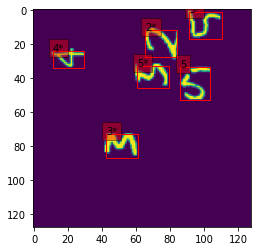

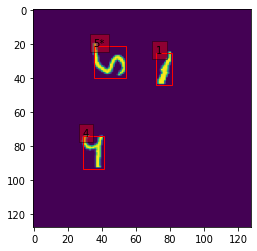

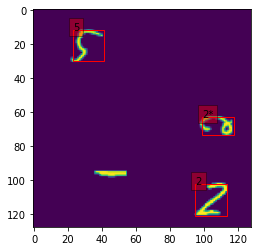

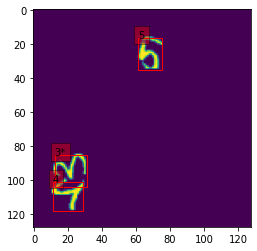

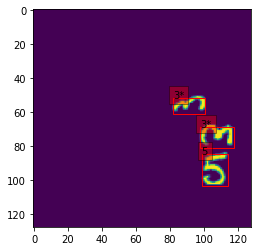

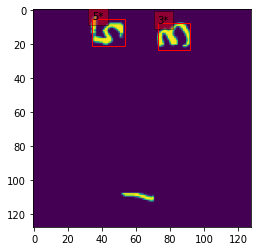

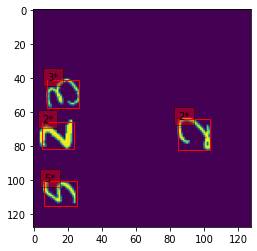

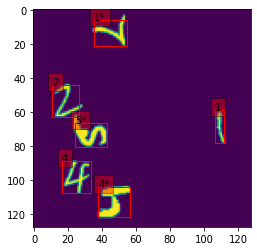

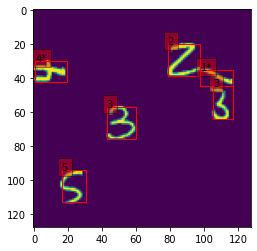

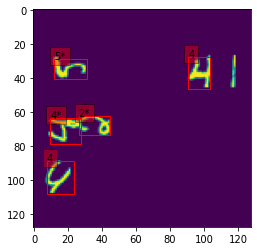

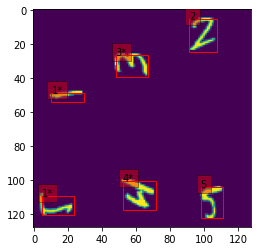

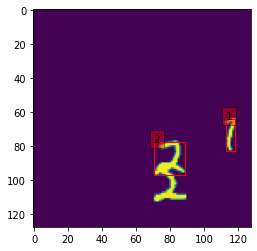

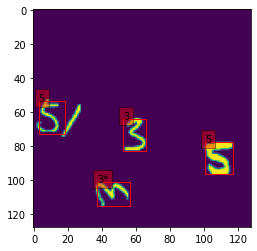

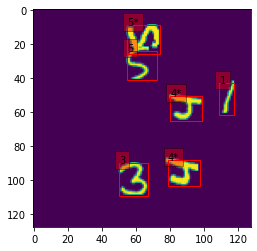

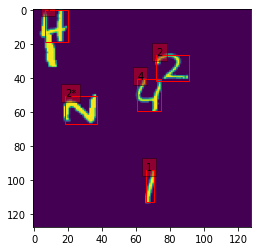

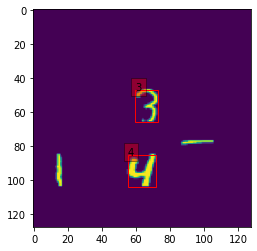

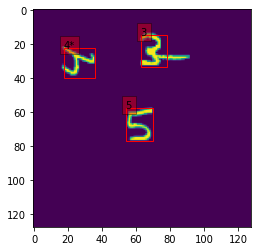

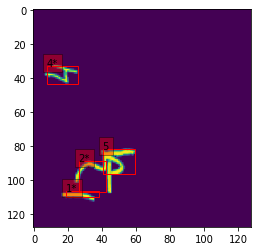

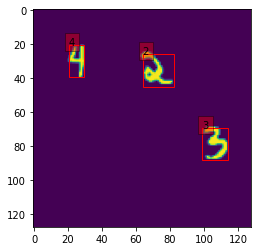

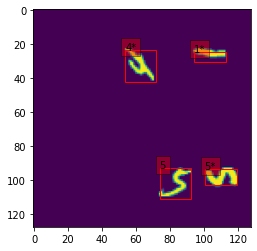

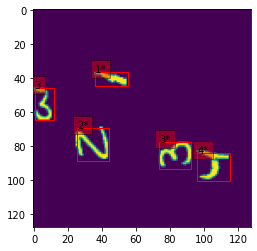

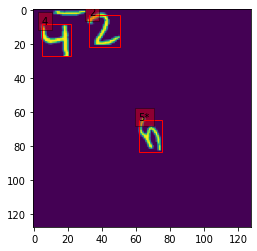

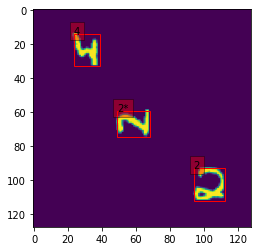

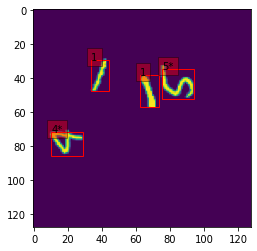

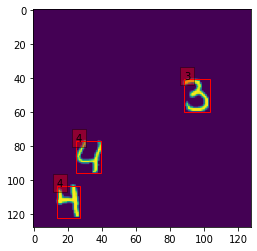

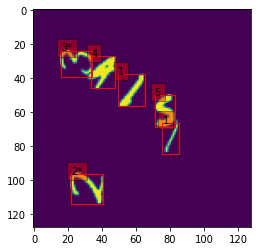

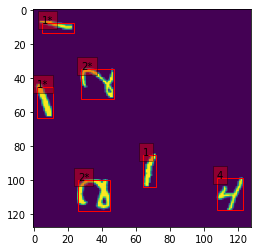

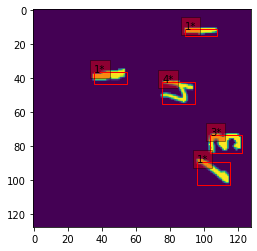

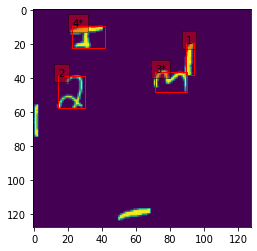

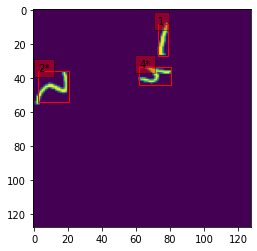

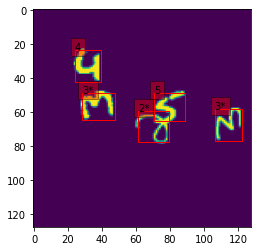

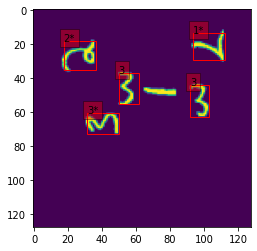

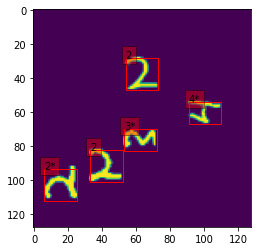

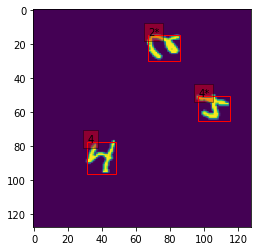

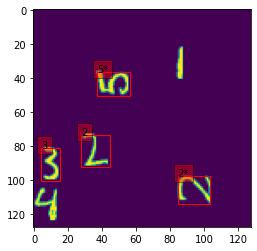

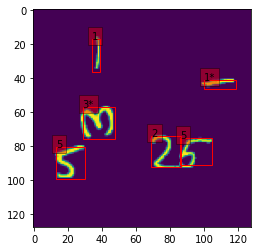

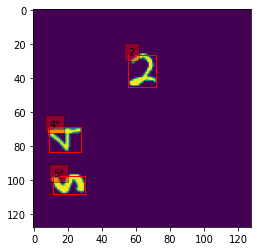

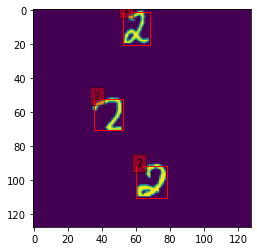

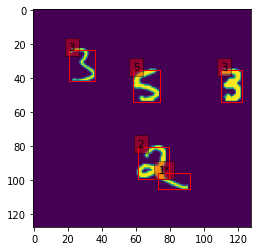

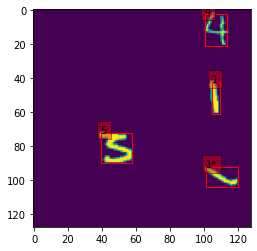

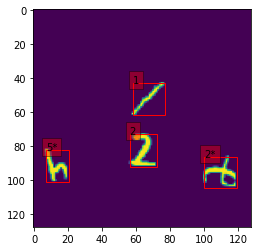

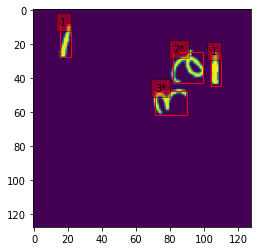

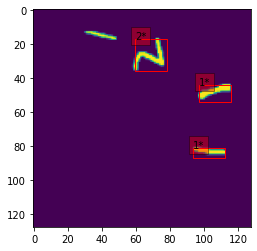

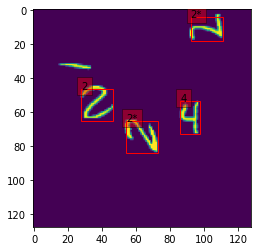

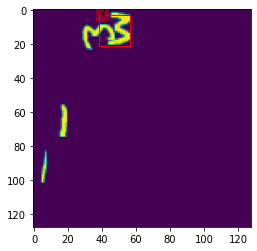

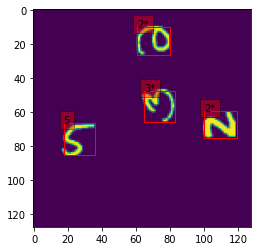

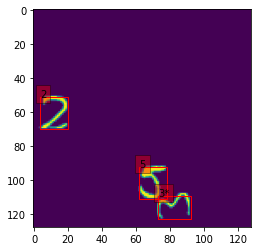

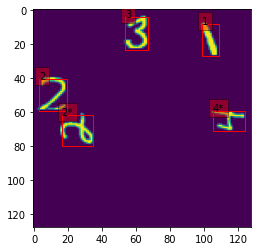

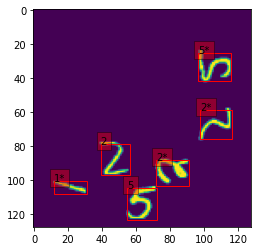

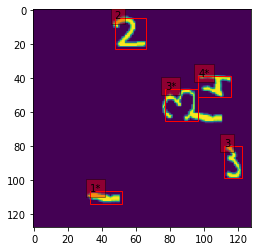

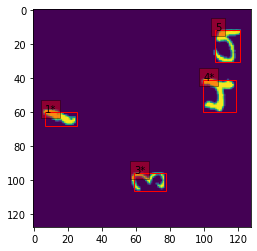

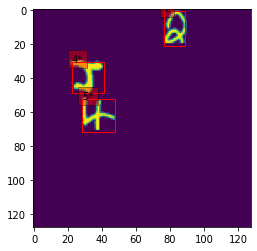

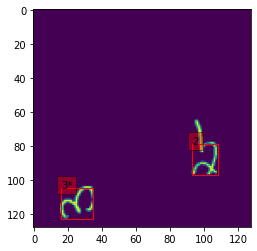

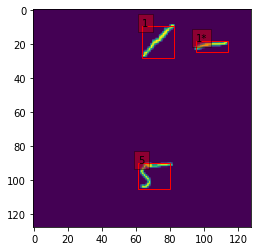

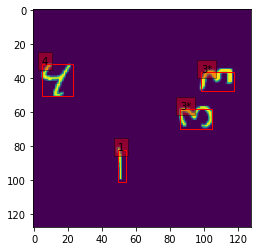

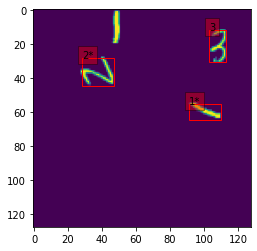

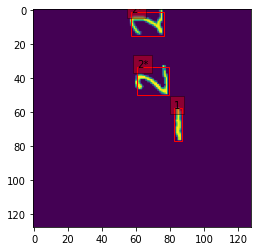

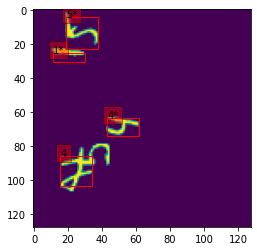

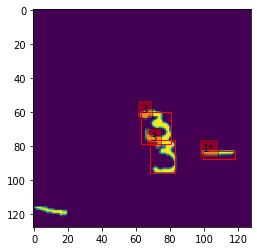

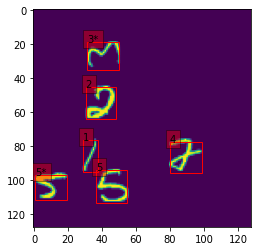

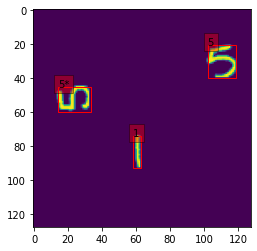

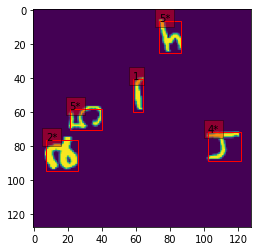

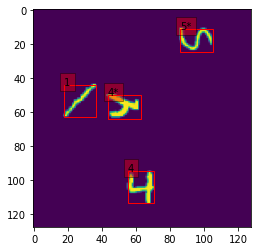

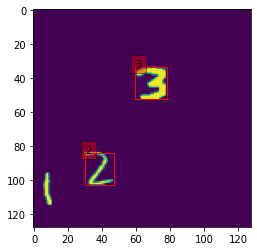

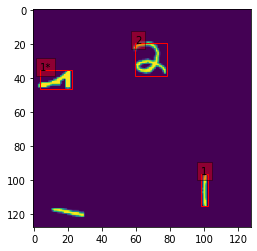

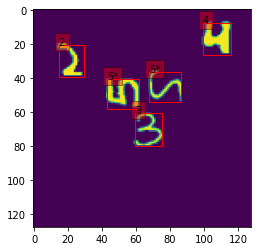

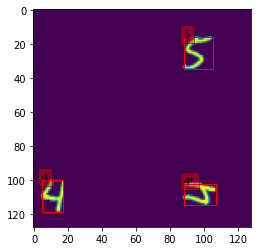

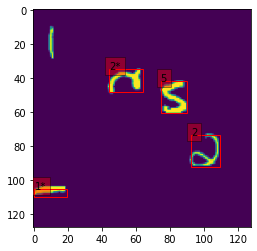

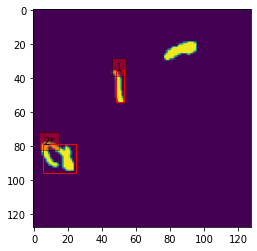

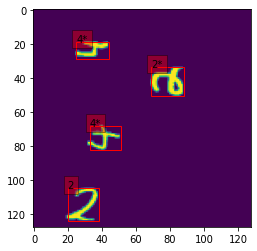

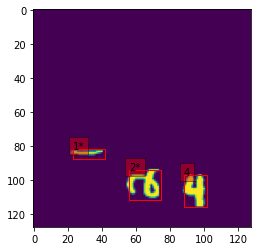

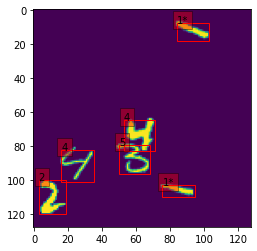

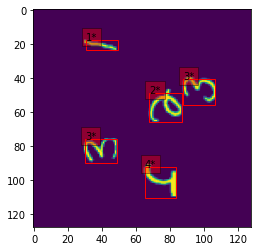

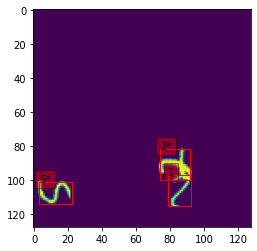

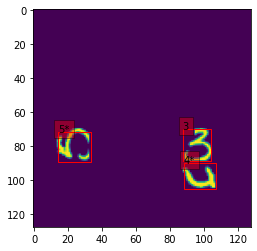

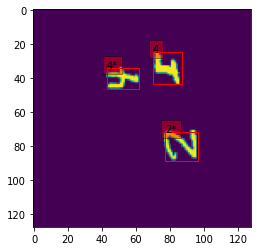

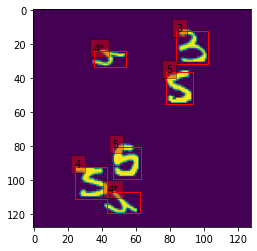

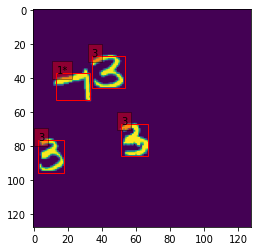

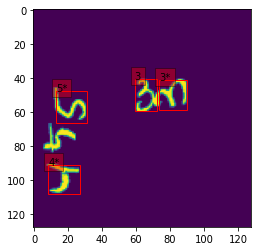

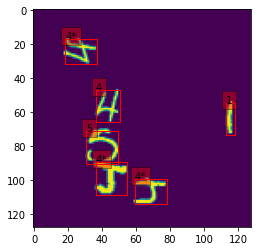

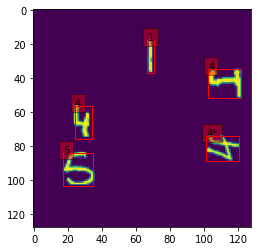

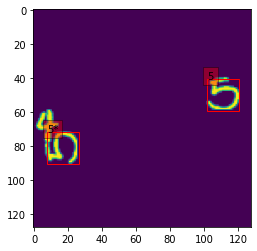

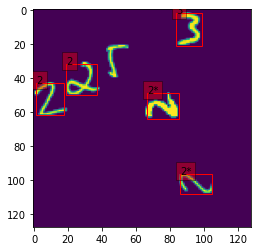

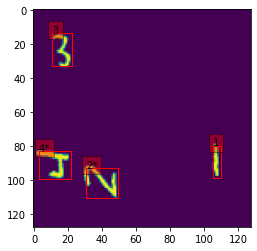

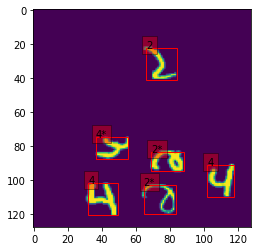

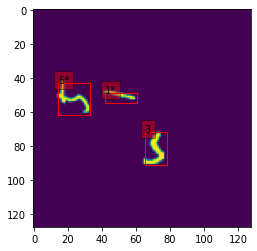

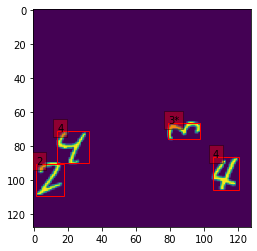

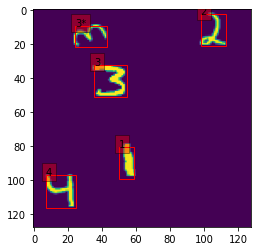

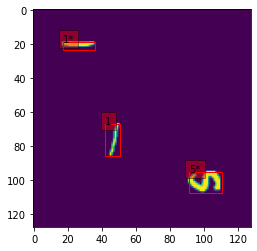

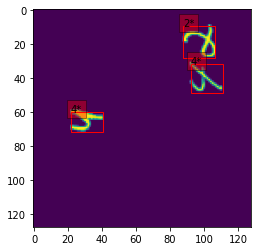

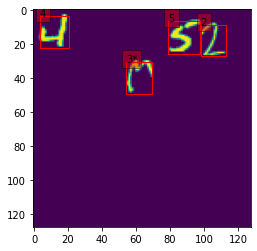

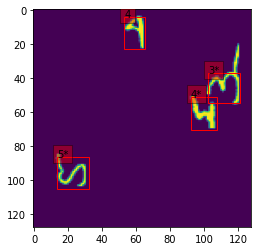

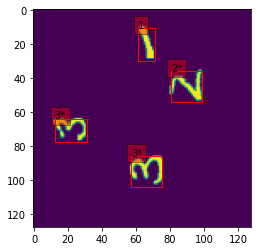

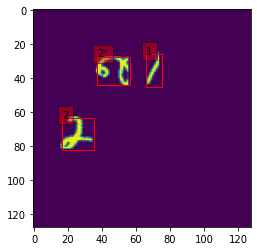

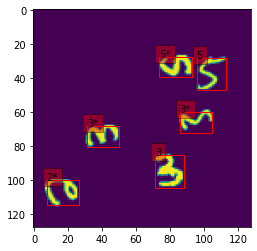

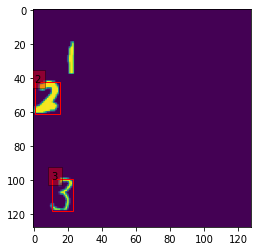

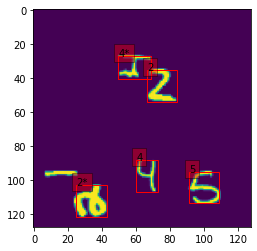

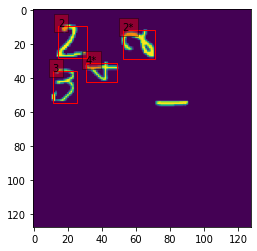

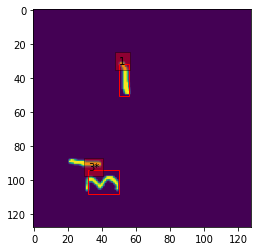

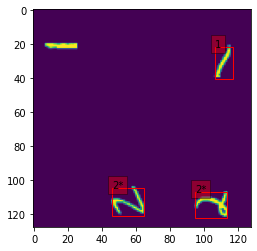

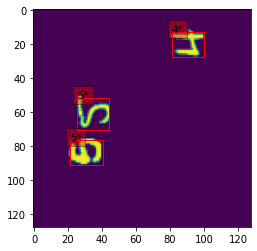

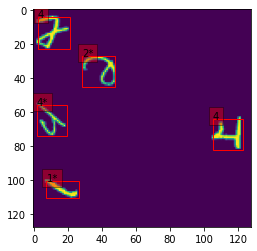

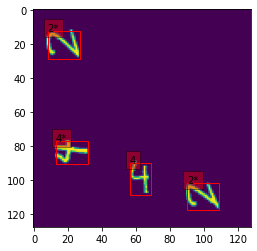

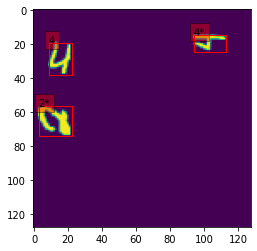

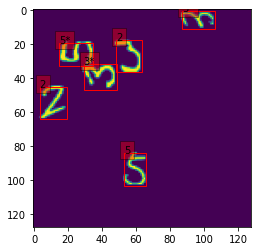

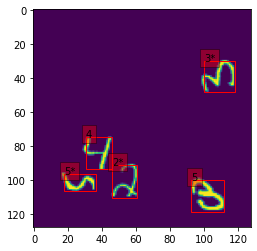

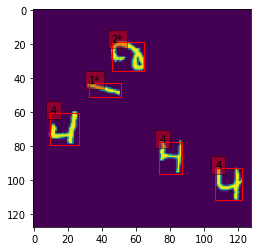

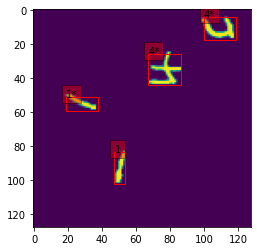

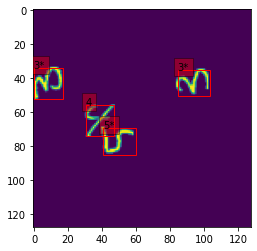

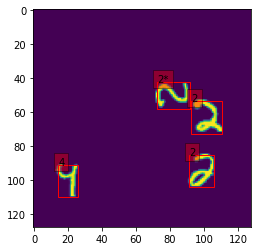

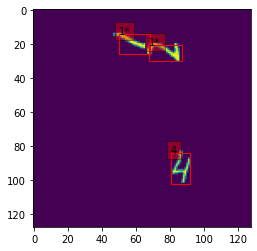

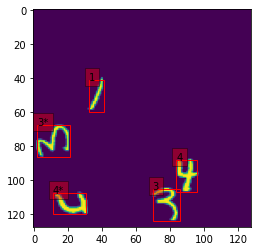

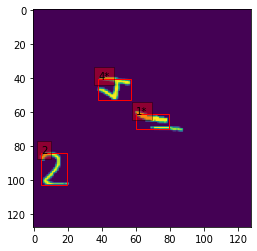

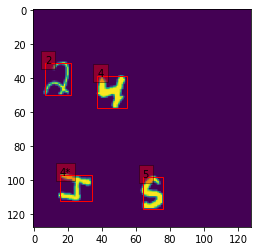

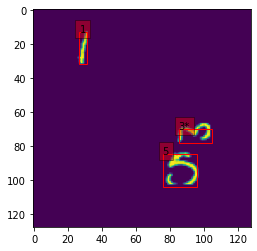

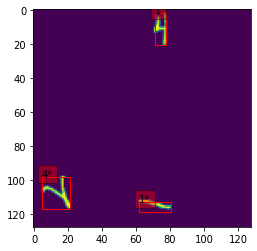

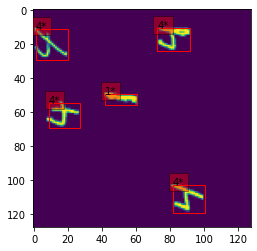

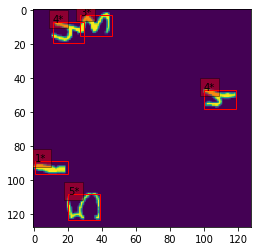

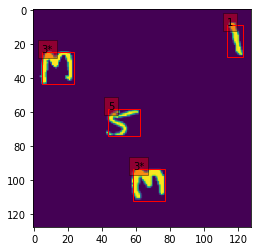

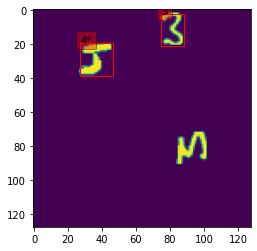

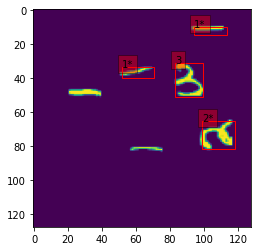

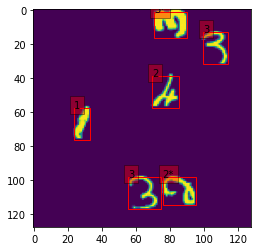

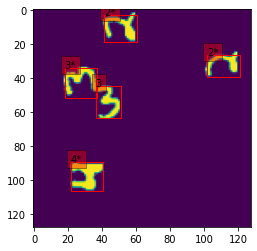

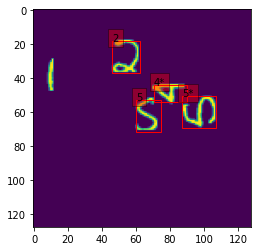

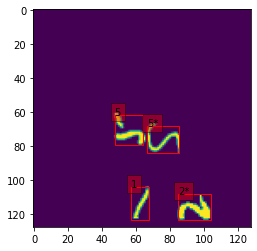

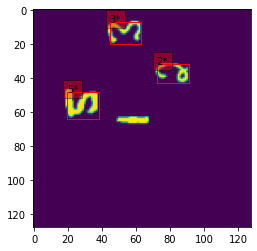

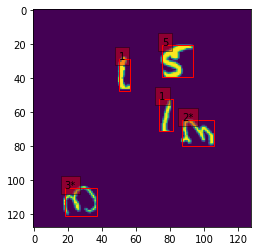

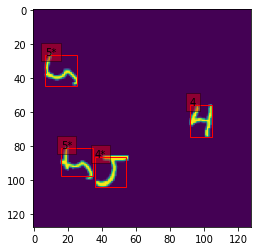

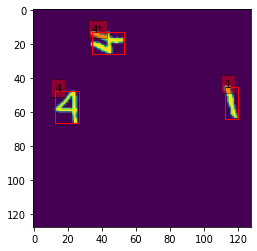

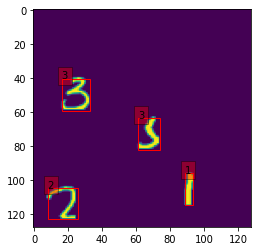

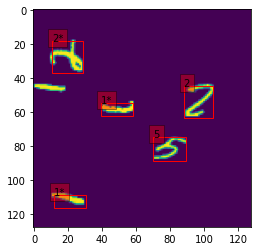

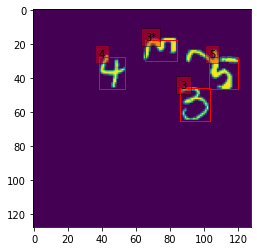

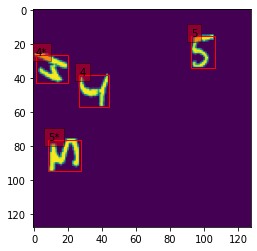

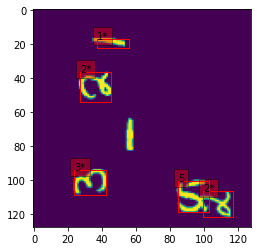

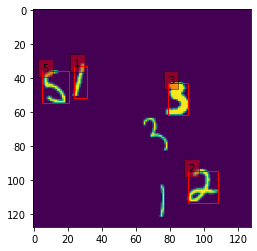

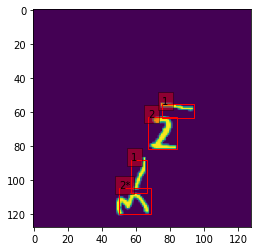

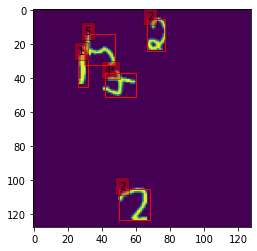

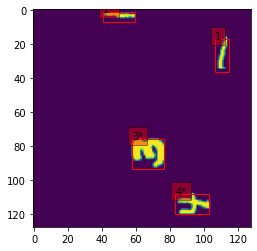

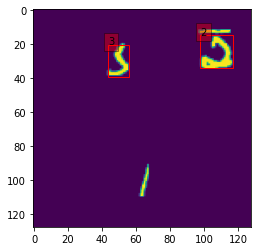

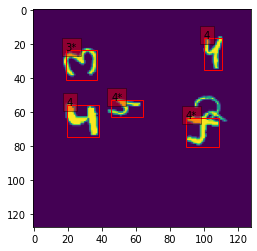

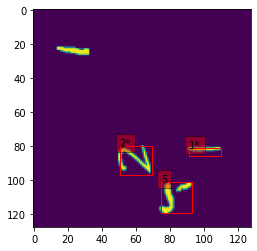

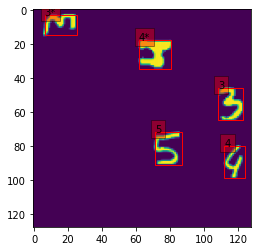

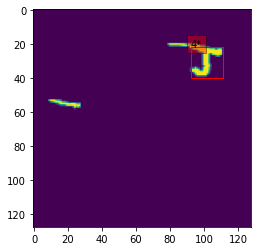

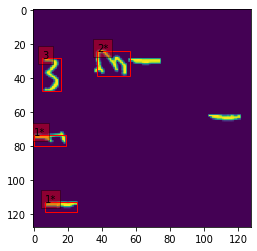

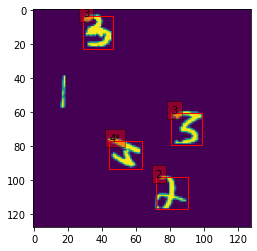

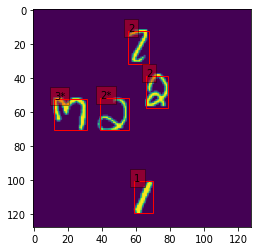

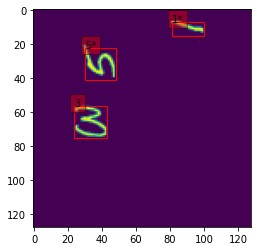

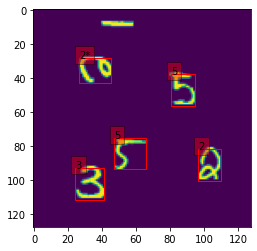

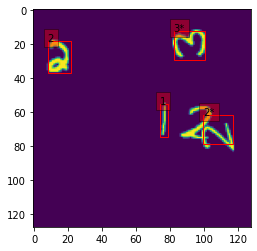

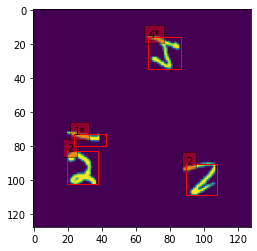

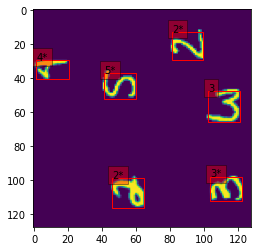

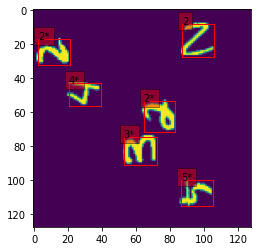

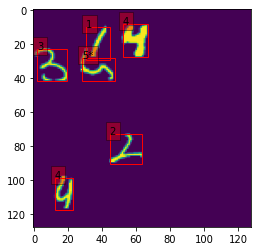

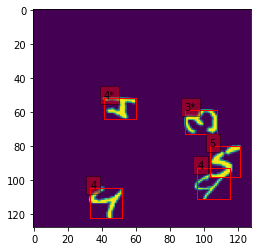

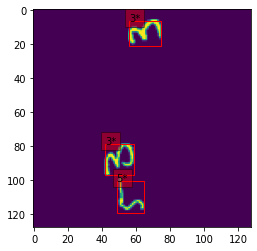

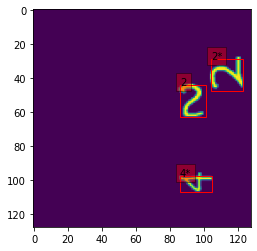

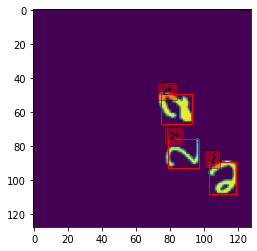

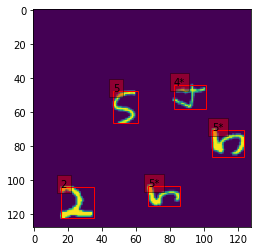

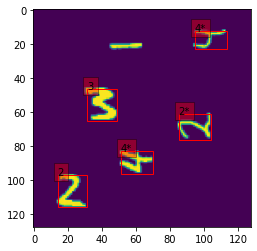

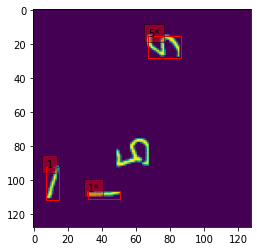

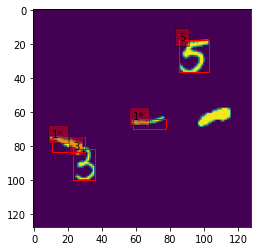

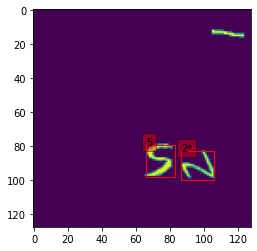

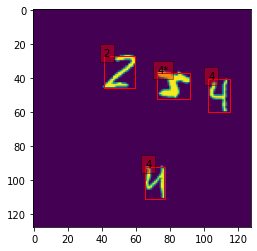

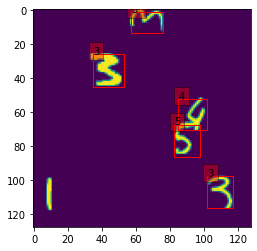

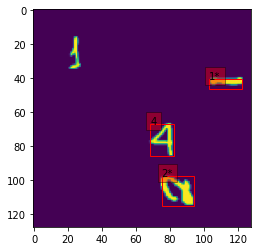

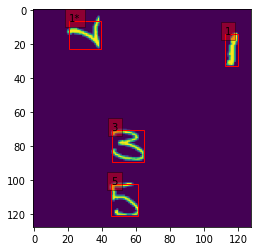

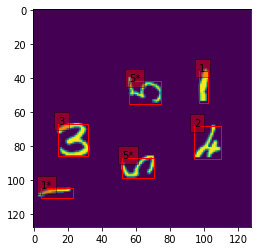

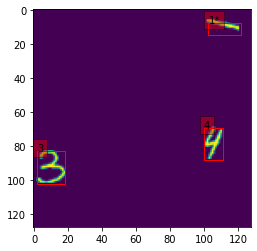

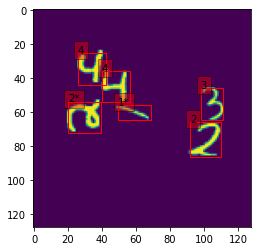

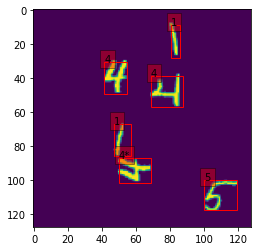

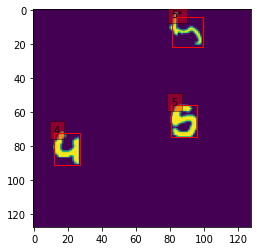

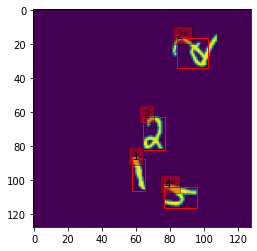

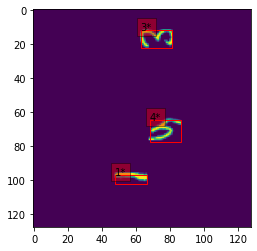

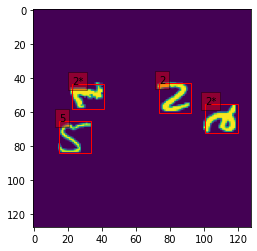

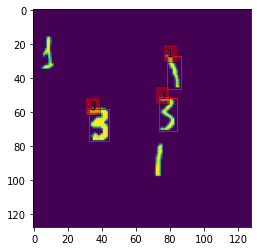

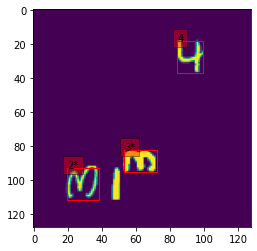

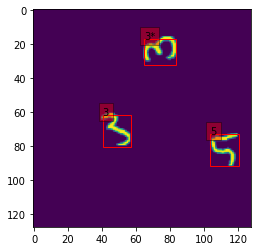

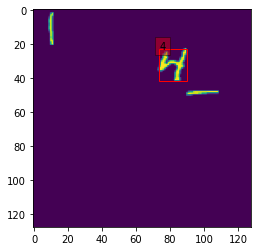

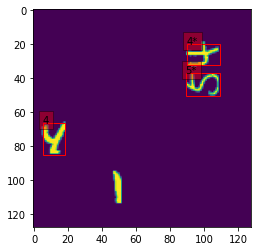

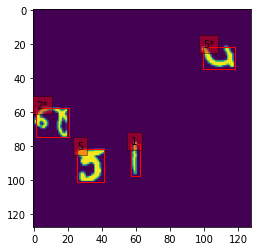

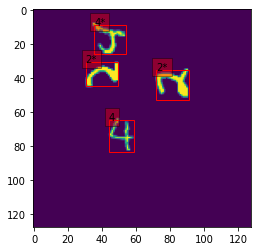

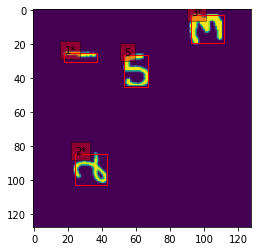

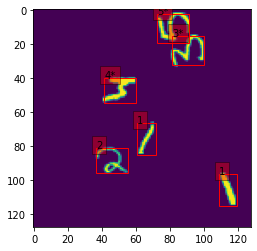

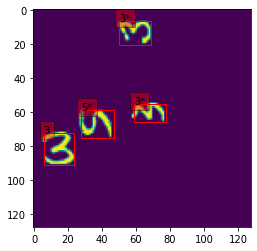

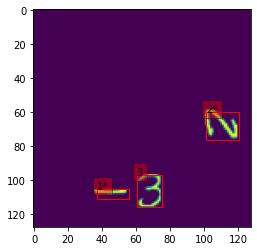

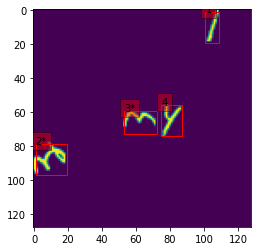

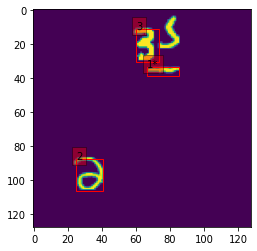

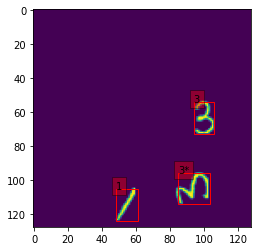

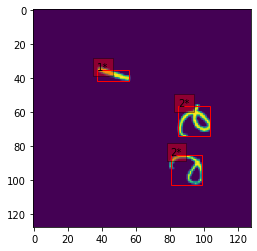

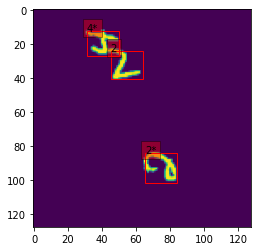

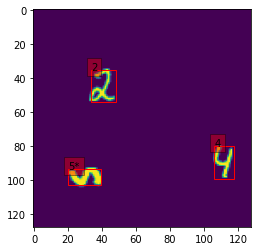

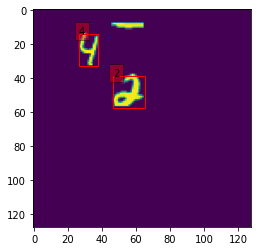

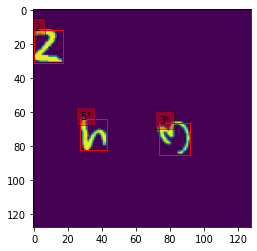

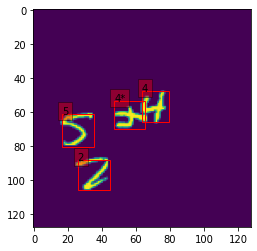

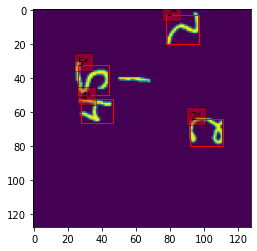

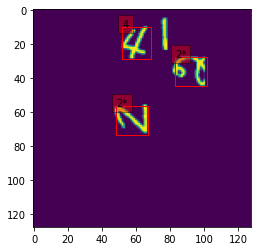

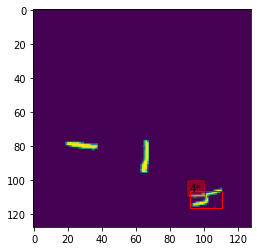

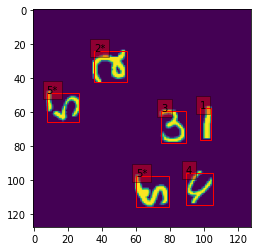

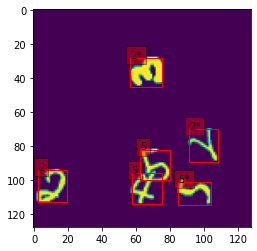

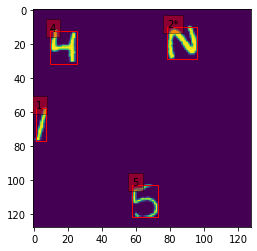

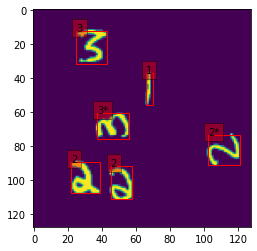

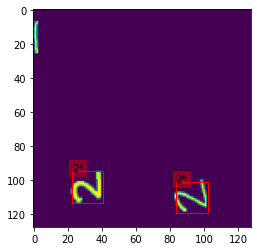

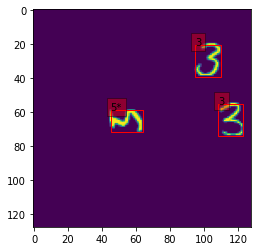

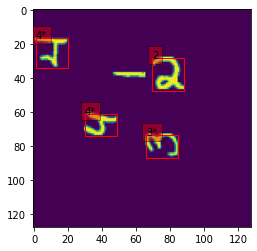

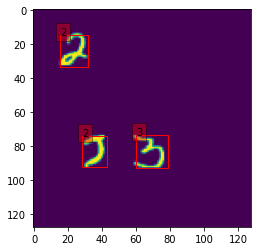

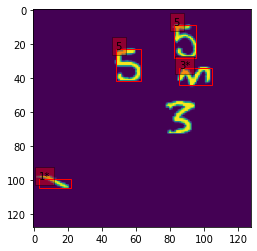

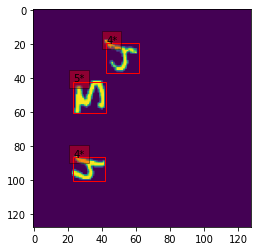

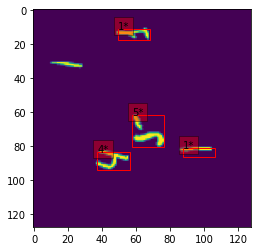

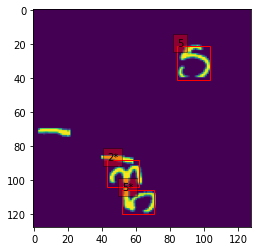

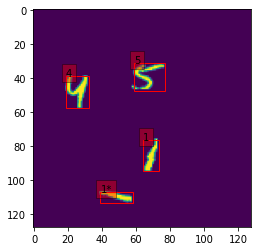

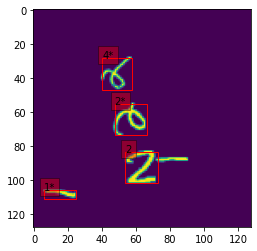

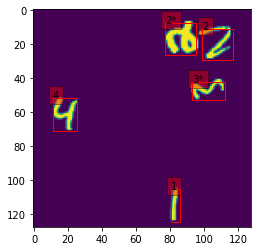

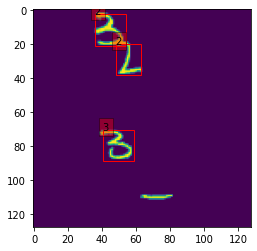

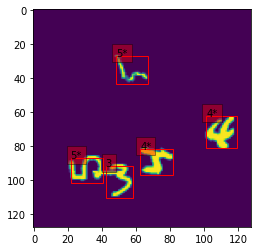

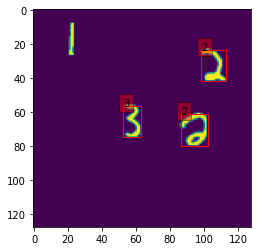

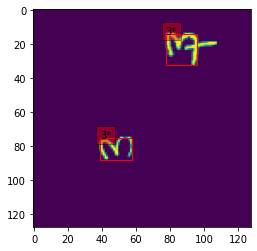

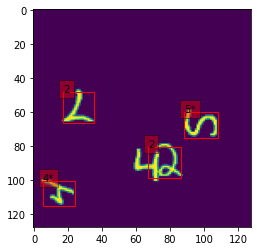

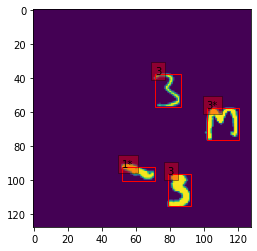

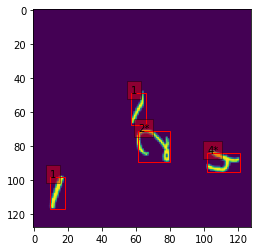

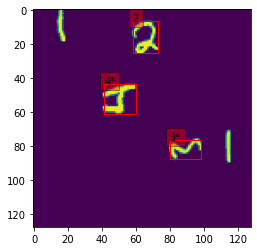

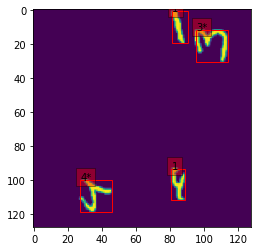

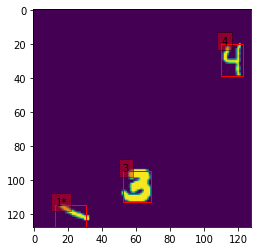

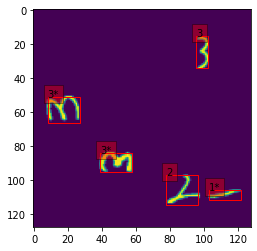

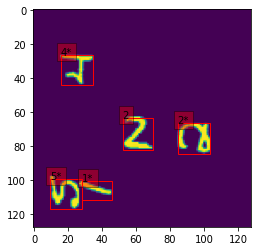

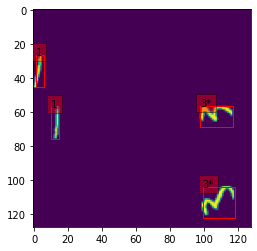

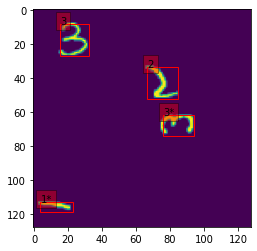

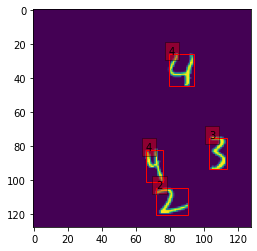

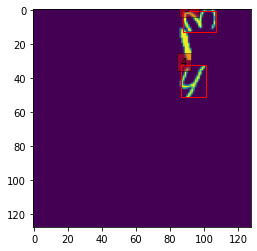

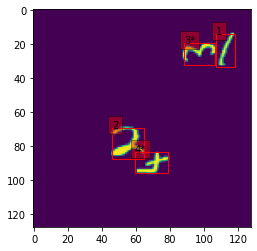

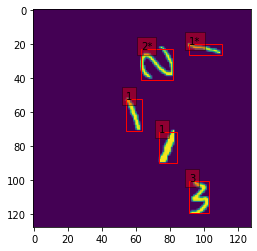

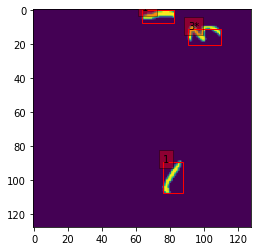

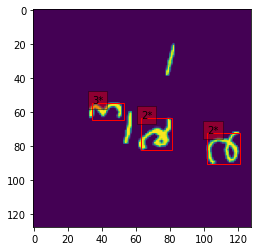

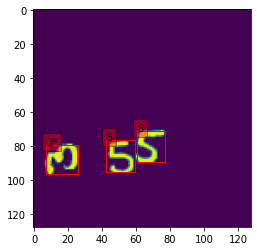

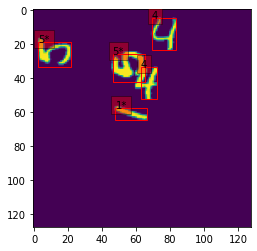

(0.0025443815746939435, 48.4375)

In [ ]:
test(model, TEST_CANVAS)

I struggled with this task for a long time, I searched the space of the internet looking for a bug after many hours of fruitless searches, I noticed that I had a badly written retina loss function. While doing the assignment, I noticed that changing the quantity of anchor_size to a larger one improved the accuracy